In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
# example : model.to(device)
# if input to device also device get in output
# inputs,labels = data[0].to(device), data[1].to(device)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# 데이터 병렬 처리
# https://tutorials.pytorch.kr/beginner/blitz/data_parallel_tutorial.html

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
batch_size = 4
num_workers = 2

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = num_workers)

testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = num_workers)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
def imgshow(trainset, classes, random_num):
    i = 1
    fig = plt.figure()
    cols = len(random_num)
    for num in random_num:
        img, label = trainset[num]
        img = img / 2 + 0.5
        to_numpy = img.numpy()
        ax = fig.add_subplot(1, cols, i)
        ax.imshow(np.transpose(to_numpy, (1, 2, 0)))
        ax.set_xlabel(classes[label])
        ax.set_xticks([])
        ax.set_yticks([])
        i += 1

In [9]:
def random_pick(max_len, pick_num):
    random_list = [random.randrange(0, max_len) for
                    _ in range(pick_num)]
    return random_list

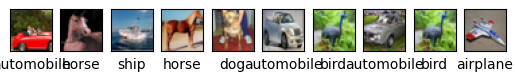

In [10]:
rand = random_pick(100, 10)

imgshow(trainset, classes, rand)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net()

In [12]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
# optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
epochs = 100

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0 and epoch != 0:
        print(f'[{epoch}/{epochs}] loss : {running_loss/2000:3f}')
    running_loss = 0.0
print("Finish Training")

In [43]:
save_path = './Best.pth'
torch.save(model.state_dict(), save_path)

In [44]:
net = Net()
net.load_state_dict(torch.load(save_path))

C:\Users\aaaa\AppData\Local\Temp\ipykernel_13832\1966896373.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(save_path))


<All keys matched successfully>

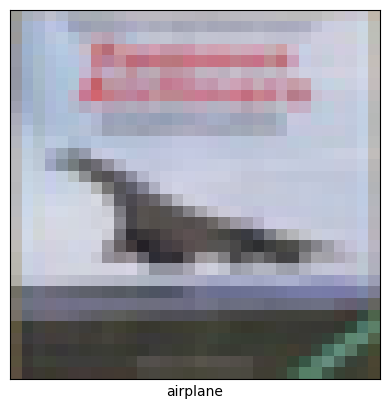

In [ ]:
rand_num = random_pick(10, 1)
images, labels = testset[rand_num[0]]

imgshow(testset, classes, rand_num)

# batchsize for unsqueeze
outputs = net(images.unsqueeze(0))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 59.1 %
Accuracy for class: automobile is 70.7 %
Accuracy for class: bird  is 41.6 %
Accuracy for class: cat   is 42.9 %
Accuracy for class: deer  is 31.8 %
Accuracy for class: dog   is 45.8 %
Accuracy for class: frog  is 58.8 %
Accuracy for class: horse is 58.8 %
Accuracy for class: ship  is 42.8 %
Accuracy for class: truck is 59.6 %
